## CORDsearch: Clustering CORD-19 by Inverted Index-Modified K-means
Developed by Cassi Larose, Paula Choconta and Connor Jordan for BIOL1595/2595 @ Brown University.
___

### Overview & Acknowledgement
CORDsearch utilizes a variant of K-Means Clustering augmented for use on string-vectors. This method is largely pioneered by Taeho Jo of Hongik University, and is directly adapted from his 2008 paper ["Inverted Index based Modified Version of K-Means Algorithm for Text Clustering"](https://citeseerx.ist.psu.edu/viewdoc/download?doi=10.1.1.148.1963&rep=rep1&type=pdf).

CORDsearch takes plain-text queries as input and returns the top 100 most relevant search results from the COVID-19 Open Research Database (CORD-19). It utilizes a pre-computed inverted index, pre-trained K-Means Clustering model, and pre-trained LDA topic model to group documents by relevancy.

# Dependencies

In [ ]:
import math, random, time
import numpy as np, pandas as pd, sklearn
from typing import List

from dataclasses import dataclass, field
import nltk; nltk.download('punkt'); nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from scipy.spatial import distance

!pip install compress_json
import pickle, gzip, compress_json
pickle.HIGHEST_PROTOCOL
import os, json, urllib.request, tarfile

from collections import OrderedDict

# Loading the Data
___

Here we parse the JSON contents of the CORD-19 database through Amazon Web Services. We save each of the ~33,000 documents in a newly created data directory. Every stage of our code includes status messages to update the user on runtime progress.

In [ ]:
def getData() -> None:
    urls = ['https://ai2-semanticscholar-cord-19.s3-us-west-2.amazonaws.com/2020-03-27/comm_use_subset.tar.gz', 
            'https://ai2-semanticscholar-cord-19.s3-us-west-2.amazonaws.com/2020-03-27/noncomm_use_subset.tar.gz', 
            'https://ai2-semanticscholar-cord-19.s3-us-west-2.amazonaws.com/2020-03-27/custom_license.tar.gz', 
            'https://ai2-semanticscholar-cord-19.s3-us-west-2.amazonaws.com/2020-03-27/biorxiv_medrxiv.tar.gz']

    # Create data directory
    try:
        os.mkdir('./data')
        print('Directory created!')
    except FileExistsError:
        print('Directory already exists!')

    #Download all files
    print('Downloading CORD-19 database...')
    
    for i in range(len(urls)):
        urllib.request.urlretrieve(urls[i], './data/file'+str(i)+'.tar.gz')
        print('Downloaded file '+str(i+1)+'/'+str(len(urls)))
        tar = tarfile.open('./data/file'+str(i)+'.tar.gz')
        tar.extractall('./data')
        tar.close()
        print('Extracted file '+str(i+1)+'/'+str(len(urls)))
        os.remove('./data/file'+str(i)+'.tar.gz')
        
    print('Done!')

# Document Extraction
___

We define our own 'Document' data structure to better organize the dataset and introduce additional functionality. They're implemented as a dataclass for the sake of readability, and come packaged with two methods to be utilized later.
* `get_freq` takes a word as input and returns its frequency in the document.
* `vectorize` converts a given document into a 'string vector' as detailed in the Jo paper linked in the overview. This process will be elaborated upon soon.

In [ ]:
@dataclass
class Document:
    """Data structure to store and interact with CORD-19 documents."""

    paper_ID : str
    title    : str = ''
    authors  : list = field(default_factory=list)
    text     : str = ''

    def get_freq(self, word : str) -> int:
        """Returns the frequency of a given word in the text."""
        return self.text.count(word)

    def vectorize(self, tokenizer, stopwords, dim : int) -> List[str]:
        """Creates a string vector of a given dimension."""
        # tokenizer :: str -> List<str>
        words = tokenizer(self.text)
        # Remove duplicate words to reduce computation time
        words = list(set(words))
        # Lowercase in lieu of stemming
        for word in words:
            word.lower()
        # Remove duplicates
        words = list(set(words))

        # Remove all punctuation, numeric characters, etc.
        def valid_word(word, stopwords) -> bool:
            """Determines if a word should be included in the string vector."""
            return not(word in stopwords) and (word.isalpha())
        words = [word for word in words if valid_word(word, stopwords)]
        
        # Sort all words by descending frequency
        words.sort(reverse=True, key=lambda w : self.get_freq(w))

        # Take only the first 'dim' words, with the paper ID
        words.insert(0, self.paper_ID)
        return words[:dim + 1]

# Data Extraction
___

Now that we have the Document data structure implemented, we simply iterate over the corpus of documents and instantiate it as a Python object. `extract` initializes an empty dictionary and populates it with each document, keyed by the paper ID. It returns the full dictionary, allowing constant lookup time for document attributes as long as we have its ID.

In [ ]:
def extract() -> dict:
    """extract :: None -> dict
    
       > Extracts the contents of the CORD-19 database
       > Represents all data as a 'Document' object
       > Returns cumulative dictionary
    """

    # Initialize empty dictionary
    docs = {}

    print('Parsing documents...'); ct = 0

    #Iterate through all files in the data directory
    for subdir, dirs, files in os.walk('./data'):
        for file in files:
            ct += 1
            if ct == 11000:
                print('1/3 of corpus parsed.')
            if ct == 22000:
                print('2/3 of corpus parsed.')
            with open(os.path.join(subdir, file)) as f:
                data_extract = json.load(f)
                
                paper_ID = data_extract['paper_id']
                title    = data_extract['metadata']['title']
                authors  = data_extract['metadata']['authors']
                text     = ''

                try:
                    for body in data_extract['abstract']:
                        text += body['text']
                except:
                    pass
                for body in data_extract['body_text']:
                    text += body['text']
                # Append the abstract and paper content together for vocabulary

                # Add the current document to the running dictionary
                docs[paper_ID] = Document(paper_ID, title, authors, text)

    print('Done!')
    return docs

# Indexing
___

We also implemented a word-level inverted index as a Python class. The index itself is a dictionary stored as an attribute of the class, while other methods provide greater functionality.

* `add_doc` takes a single Document and incorporates all of its text into the index, saving each occurrence of a word in the relevant space in the `self.index` dictionary. It tokenizes the text into words, applies a blanket lowercase, and removes all English stopwords from NLTK.
* `freq_table` constructs a new dictionary to store all of the document frequencies of each word. Not only does this turn what would be a linear computation into constant-time lookup, but it allows us to transmute the index dictionary in ways that will aid us later on down the line.

In [ ]:
class InvertedIndex:
    """Word-level inverted index data structure."""
    
    def __init__(self, tokenizer, stopwords : list=[]):
        
        self.tokenizer = tokenizer
        self.stopwords = set(stopwords)
        
        self.index = {}
        # key : word, val : List<paper_ID>

        # Used for memoizing the size of document frequencies
        self.intersections = {}
        
    def add_doc(self, doc : Document):
        """Incorporates the text of a document into the index."""

        # tokenizer :: str -> List<str>
        words = self.tokenizer(doc.text)
        #Lowercase in lieu of stemming
        for word in words:
            word.lower()
        ID = doc.paper_ID
        position = 0

        for word in words:
            if word in self.stopwords:
                pass
            elif not(word in self.index.keys()):
                self.index[word] = [ID]
            else: 
                self.index[word].append(ID)
                position += 1

    def freq_table(self) -> None:
        """Store the frequency of each word in a dict."""

        self.freq = {}
        for word in self.index.keys():
            self.freq[word] = len(self.index[word])

# String Vectors - What Are They?
___

The difficulty of clustering typical numerical vectors is the so-called 'curse of dimensionality'; the more total information we account for, the sparser each vector becomes and the less information any individual vector can convey. Numerical vectors used in the K-Means Algorithm reserve each dimension for a given term, and for each vector the corresponding component is its TF-IDF score.

String vectorization takes a different, more abstract approach to defining the decision space. Each basis vector, instead of a constant term, is a ranking of document frequency. The components of each vector are the most frequent words in the document, sorted by that frequency. These vectors are extremely dense, allowing us to choose our dimension and cut down on runtime while still maintaining a reasonable vector space.
___

However, this means we need to define a new, robust decision metric and processes to facilitate K-Means on this new type of vector.

## Semantic Similarity
___

Using document frequency for each word, ($df(w)$), we can define the *semantic similiarity* between two words as
$$ss(w_i, w_j) = \frac{2df(w_i, w_j)}{df(w_i) + df(w_j)},$$
where $df(w_i, w_j)$ represents the number of times both words occur in the same document.

This allows us to define another metric, *vector similarity*, between two string vectors:
$$sim(\frac{1}{d}\sum_{k=1}^d w_{ik}, w_{jk}).$$

Because vector similarity obeys the triangle inequality, it is a robust distance metric over our decision space! The downside is its complexity, even with the pre-computed index at our fingertips. Calculating the numerator of semantic similarity, the overlap between two documents, requires us to turn the occurrence lists of both words into sets, removing duplicates, and finding the length of the intersection of those two sets. Doing this hundreds of thousands of times is not practical and would make training take over 15 hours. So, we memoize!

## Memoization
___

Memoization involves creating an empty array and filling it in whenever you finish a subtask. That way, if you've already computed something, you can retrieve that result in constant lookup time. For `sem_sim`, our implementation of semantic similarity, we store calculations in the `idx.intersections` 2D array, which is really a nested dictionary. This storage makes computation extremely efficient and actually gets faster over time.

In [ ]:
class Indexed_K_Means:
    """Data structure for modified K-Means clustering algorithm."""

    def __init__(self, k=10, max_iter=25):
        self.num_clusters = k
        self.max_iter = max_iter

    def seeds(self, data):
        """Choose random centroids to start K-Means."""
        return random.sample(data, self.num_clusters)

    def sem_sim(self, w1: str, w2 : str, idx) -> float:
        """Computes the semantic similarity of two words."""

        # Don't want to include stopwords
        if (w1 not in idx.index) or (w2 not in idx.index):
            return 0

        # Check memoization array for precomputations
        if w1 not in idx.intersections.keys():
            idx.intersections[w1] = {}
        if w2 not in idx.intersections[w1].keys():
            # If this is the first time comparing w1/w2, compute the intersect
            w1_docs = idx.index[w1]; w2_docs = idx.index[w2]
            idx.intersections[w1][w2] = len(w1_docs.intersection(w2_docs))

        # Return the sem sim using index attributes
        return 2 * idx.intersections[w1][w2] / idx.freq[w1] + idx.freq[w2]

    def sim(self, vec1 : list, vec2 : list, idx) -> float:
        """Computes the similarity between two string vectors."""
        s = 0; dim = min(len(vec1), len(vec2))
        for i in range(1, dim):
            # Sum the sem similarity of each component in the vectors
            s += self.sem_sim(vec1[i],vec2[i], idx)

        # Normalize to dimension of vector
        return ((1/dim) * s)

    def fit(self, data, idx):
        """Clusters given data into num_clusters."""

        print('Training K-Means model...')

        # Randomly select seed centroids
        self.centroids = self.seeds(data)
        print('Seed found!')

        # Create initial prototype clusters
        self.classifications = {}
        for label in range(self.num_clusters):
            self.classifications[label] = []

        # Iterate algorithm for specified number of times
        for i in range(self.max_iter):

            print('Cluster round '+str(i))

            self.make_clusters(data, idx)

            self.update_centroids()

        print('Done!')

    def make_clusters(self, data, idx) -> None:

        for vec in data:
            # Keep track of running maximum similarity
            if len(vec) <= 49:
                continue
            best_sim = -math.inf; best_label = 0

            # Check each centroid to see if it's most similar
            for i in range(self.num_clusters):
                curr_sim = self.sim(vec, self.centroids[i], idx)
                if curr_sim > best_sim:
                    # Update values
                    best_sim = curr_sim
                    best_label = i
            # Add vector to list by cluster label
            clus = self.classifications[best_label]
            clus.append(vec)
            self.classifications[best_label] = clus

    def update_centroids(self) -> None:
        """Selects new mean centroids based on current clusters."""

        # Delete all previous centroids
        prev_centroids = self.centroids.copy()
        self.centroids.clear()
        for cluster in self.classifications.keys():
            if len(self.classifications[cluster]) == 0:
                new_cent = []
                new_cent.append(prev_centroids[cluster])

            else:
                new_cent = []
                dim = 50
                for i in range(1, dim):
                    # Randomly sample each component from the cluster's vectors
                    vec = random.sample(self.classifications[cluster], 1)[0]
                    new_cent.append(vec[i])
            # Add the new centroid to the running list
            self.centroids.append(new_cent)

    def predict(self) -> int:
        """Returns list of predicted cluster labels."""
        
        # Pretty self-explanatory, but I'm glad you're reading the comments!
        return self.classifications

# Modified K-Means
___

We can use vector similarity as our method of clustering string vectors. The only question left is how we compute our centroids, the 'average' vectors that define each cluster. We employed a stochastic method, randomly selecting each $i$th component of the 'mean' vector from the $i$th index of all the vectors in that cluster.
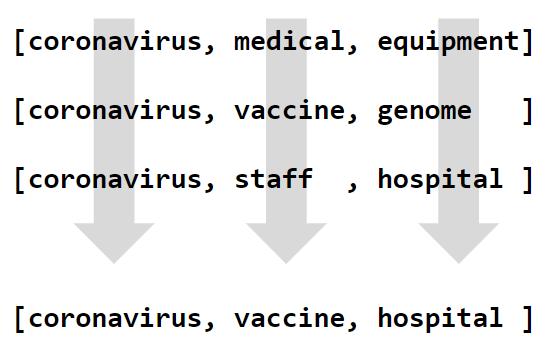
After fitting the clusters to our data set, we can return the clusters in dictionary form, keyed by their cluster ID.

# Organization
___

`organize` simply instantiates and trains the index and clustering algorithm, saving the results in JSON format for later reference. This prevents us from having to retrain every time we search.

In [ ]:
def organize(doc_list : List[List[str]]):
    """
       Vectorizes, clusters and creates topic models for documents in 
       the corpus.
    """

    # Instantiate the Index data structure
    idx = InvertedIndex(
        nltk.word_tokenize,
        nltk.corpus.stopwords.words('english'))
    
    ### IF YOU WANT TO RECOMPILE THE INVERTED INDEX, UNCOMMENT BELOW UNTIL 'END'
    #
    print('Compiling inverted index...')
    start_time = time.time()
    
    ct = 0
    for doc in doc_list.values():
        print(ct)
        idx.add_doc(doc)
        ct += 1
    
    print("Done! Indexing took %s seconds. ---" % (time.time() - start_time))
    
    # Save index in Pickle for later reference (no recomputation)
    idx_file = gzip.open('idx_file', 'ab') 
    pickle.dump(idx.index, idx_file)                      
    idx_file.close()
    #
    ### END ####################################################################

    # Read inverted index from Pickle
    print('Importing inverted index...')
    idx_file = gzip.open('idx_file', 'rb')
    inv_index = pickle.load(idx_file)
    idx.index = inv_index
    print('Done!')

    # Record the frequency of each word
    idx.freq_table()
    # Convert word usage to sets for intersection calculation
    for word in idx.index.keys():
        idx.index[word] = set(idx.index[word])

    ### IF YOU WANT TO RECOMPILE THE STRING VECTORS, UNCOMMENT BELOW UNTIL 'END'
    #
    print('Vectorizing documents...')
    vec_list = []; ct = 0
    # Compile all feature vectors for documents in corpus
    for doc in doc_list.values():
        vec_list.append(doc.vectorize(
            nltk.word_tokenize,
            nltk.corpus.stopwords.words('english'),
            50)) # dim = 50
        print(ct); ct += 1
    print('Done!')
    #
    vector_file = open('vectors', 'w')
    json.dump(vec_list, vector_file)                      
    vector_file.close()
    #
    ### END ####################################################################

    # Import precomputed vectors from JSON
    print('Importing string vectors...')
    vector_file = open('vectors', 'r')
    vecs = json.load(vector_file)
    vec_list = vecs
    print('Done!')

    ### IF YOU WANT TO RECOMPILE THE CLUSTERS, UNCOMMENT BELOW UNTIL 'END'
    #
    print('Clustering string vectors...')
    start_time = time.time()
    # Cluster data using K-Means
    KMeans = Indexed_K_Means(max_iter=25)
    KMeans.fit(vec_list, idx)
    # Attach labels to string vectors
    clusters = KMeans.predict()
    print("Done! Clustering took %s seconds. ---" % (time.time() - start_time))
    
    cluster_file = open("cluster_file.json.gz", 'wt') 
    compress_json.dump(clusters, "cluster_file.json.gz")                      
    cluster_file.close()
    #
    ### END ####################################################################

    # Import precomputed clusters from JSON
    print('Importing clusters...')
    cluster_file = gzip.open("cluster_file.json.gz", 'rt')
    clusters = json.load(cluster_file)
    print('Done!')

    # Compile the keywords for each cluster, store in a dictionary
    # Keyed by cluster ID, values are lists of vectors
    keywords = {}
    for ID, cluster in clusters.items():
        keywords[ID] = []
        for vec in cluster:
            keywords[ID].extend(vec[1:])
        # Remove all duplicate keywords
        keywords[ID] = list(OrderedDict.fromkeys(keywords[ID]))

    return idx, keywords, clusters

# Retrieval - Vector Space Model
___

To rank our search results, we simply tokenize the query and compute its similarity to all of the vectors in the string-vector decision space. The results are sorted, the top 100 most relevant are chosen to be presented, and returned in a list of lists.

In [ ]:
def retrieve(keywords, clusters, queries, idx):
    """Retrieves the top 100 documents and sorts by similarity."""
    
    def sem_sim(w1: str, w2 : str, idx) -> float:
        """Computes the semantic similarity of two words."""

        # If a query term is not seen anywhere in the vocabulary, return 0 rank.
        #
        # In the worst case, the query will be complete nonsense, and the model
        # will just return 100 results which may or may not be correlated.
        if (w1 not in idx.index) or (w2 not in idx.index):
            return 0

        if w1 not in idx.intersections.keys():
            idx.intersections[w1] = {}
        if w2 not in idx.intersections[w1].keys():
            w1_docs = idx.index[w1]; w2_docs = idx.index[w2]
            idx.intersections[w1][w2] = len(w1_docs.intersection(w2_docs))

        return 2 * idx.intersections[w1][w2] / idx.freq[w1] + idx.freq[w2]

    def word_sim(q : str, vec : List[str], idx, doc_level : bool=False) -> float:
        """Computes the similarity between two string vectors."""

        # 'doc_level' refers to whether or not we are calculating relevance with
        # respect to cluster keywords or document vectors. In the case of 
        # document-level ranking, we want to weight less frequent words more 
        # highly.

        if (len(q) == 0) or (len(vec) == 0):
            return 0

        # Measure the edit distance between each vector
        s = 0; dim = len(vec)
        for i in range(0, dim):
            if doc_level:
                # Weight less frequent words
                weight = (i + 1 / dim)
            else:
                # No inherent ordering in words, equal weight
                weight = 1
            # Return the weighted similarity
            s += sem_sim(q,vec[i], idx) * weight

        return ((1/(dim + 1)) * s)

    # Initialize list for return
    result_list = []

    # Iterate through each query in the list
    for q in queries:
        
        # Preprocess the query into separate, stemmed words
        q_words = nltk.word_tokenize(q)
        for word in q_words:
            word.lower()
        for stop in nltk.corpus.stopwords.words('english'):
            if stop in q_words:
                q_words.remove(stop)

        # Method of ranking relevancy
        def rank(strings : List[str], idx, doc_level : bool=False):
            r = 0
            for word in q_words:
                r += word_sim(word, strings, idx, doc_level)
            return r

        # Sort each cluster by relevancy of its keywords
        relevant = list(keywords.keys())
        relevant.sort(
            reverse=True, key=lambda x : rank(keywords[x], idx))

        n = 0
        # Iterate until all 100 results are compiled
        print('Compiling results...')
        while n < 100:
            counter = 0
            # Sort the docs in each cluster by relevance to query
            clusters[relevant[counter]].sort(
                reverse=True, key=lambda x : rank(x[1:], idx))
            docs = clusters[relevant[counter]]
            # If there are not enough results in the current cluster...
            if len(relevant[counter]) < (100 - n):
                result_list.extend([doc[0] for doc in docs])
                # ...move on to the next cluster
                counter += 1
                # If there ARE enough, just add all of them
            else:
                result_list.extend([doc[0] for doc in docs[:(100 - n)]])
            n = len(result_list)

        # Print results
        print_results(q, result_list)
        # Add query result to running list
        result_list.append(result_list)

    # Return list of lists of results
    return result_list

# Printing and Presenting Results
___

We included a simple function to print the search results in an aesthetically pleasing manner. It ranks the results from 1-100.

In [ ]:
def print_results(query : str, results : List[str]) -> None:
    """Prints query results in readable format."""

    print('Your search for "' + query + '" returned the following results:')
    for i in range(100):
        print(str(i+1)+'. ' + results[i])

# Main Method
___

Here's where it all comes together! We simply call all of the functions we defined above to cluster and rank a given list of queries.

In [ ]:
def main():

    #Initialize the random seed for ML applications
    random.seed(1595)

    # Load the CORD-19 database
    getData()

    # Extract relevant info and create list of Docs
    doc_list = extract()

    # Extract and organize the data
    idx, keywords, clusters = organize(doc_list)

    # ========================= INPUT QUERIES HERE ============================#
    q = ['coronavirus origin',
         'coronavirus response to weather changes',
         'coronavirus immunity'
    ]
    #==========================================================================#

    # Information retrieval given queries
    results = retrieve(keywords, clusters, q, idx)

main()

# Thank you!

Thanks for checking out our project! We appreciate all feedback you might have!